In [ ]:
# Uncomment and run the commands below if imports fail
# !pip3 install matplotlib pandas seaborn jovian numpy pytorch torch torchvision

: 

In [2]:

import torch
import jovian
import torchvision
import torch.nn as nn

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
%matplotlib inline

In [5]:
project_name='forest-fires-regression-prediction' # will be used by jovian.commit

In [3]:
df_raw = pd.read_csv('../csv/forestfires.csv')
df_raw.tail()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00
516,6,3,nov,tue,79.5,3.0,106.7,1.1,11.8,31,4.5,0.0,0.00


In [7]:
df = df_raw.drop(['X','Y','month','day','area','DMC','DC'], axis=1)
df.tail()

,FFMC,ISI,temp,RH,wind,rain
0,86.2,5.1,8.2,51,6.7,0.0
1,90.6,6.7,18.0,33,0.9,0.0
2,90.6,6.7,14.6,33,1.3,0.0
3,91.7,9.0,8.3,97,4.0,0.2
4,89.3,9.6,11.4,99,1.8,0.0


<AxesSubplot:>

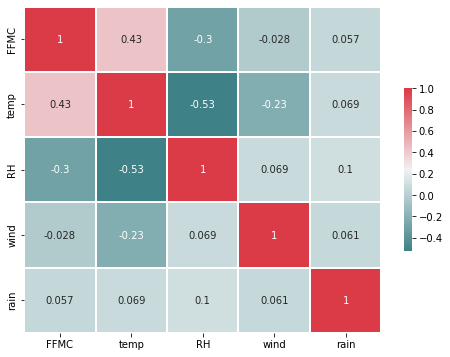

In [8]:
# Compute the correlation matrix
corr_matrix = df.drop(['ISI'], axis=1).corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(200, 10, as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap, annot=True,linewidth = 0.1,  cbar_kws={"shrink": .5})

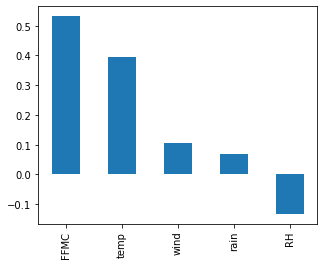

In [9]:
corr_with_isi = df.corr()['ISI'].sort_values(ascending=False)
plt.figure(figsize=(5,4))
corr_with_isi.drop('ISI').plot.bar()
plt.show();

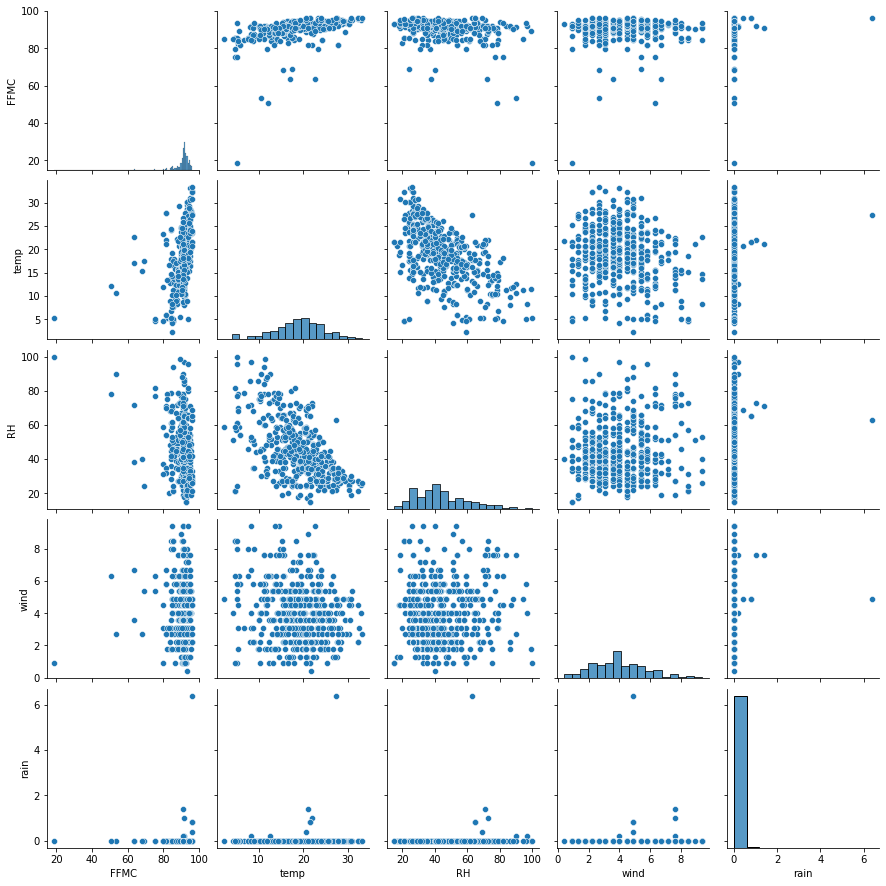

In [10]:
sns.pairplot(df[['FFMC', 'temp', 'RH', 'wind', 'rain']])
plt.show()

In [11]:
num_rows = df.shape[0]
num_rows

517

In [12]:
print(df.columns)
#cols number
print(df.shape[1])

Index(['FFMC', 'ISI', 'temp', 'RH', 'wind', 'rain'], dtype='object')
6


In [13]:
input_cols = ['FFMC','temp','RH','wind','rain']
output_cols = ['ISI']

In [19]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Error: Failed to read the Jupyter notebook. Please re-run this cell to try again. If the issue persists, provide the "filename" argument to "jovian.commit" e.g. "jovian.commit(filename='my-notebook.ipynb')"


In [20]:
#using pytorch as framework, so we have to convert all to pytorch format
def dataframe_to_arrays(dataframe):
    #copying dataframe for later use
    dataframe1 = dataframe.copy(deep=True)
    #converting to numpy
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [23]:
inputs_array, targets_array = dataframe_to_arrays(df)

In [25]:
inputs_array.shape , targets_array.shape

((517, 5), (517, 1))

In [26]:
#converting numpy arrays to pytorch format
inputs = torch.from_numpy(inputs_array).float()
targets = torch.from_numpy(targets_array).float()

In [27]:
inputs.shape, targets.shape

(torch.Size([517, 5]), torch.Size([517, 1]))

In [28]:
dataset = TensorDataset(inputs, targets)

In [29]:
val_percent = 0.19
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset, [train_size,val_size])

In [30]:
batch_size = 32

In [31]:
#creating training and validation loader
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [32]:
input_size = len(input_cols)
output_size = len(output_cols)
input_size , output_size

(5, 1)

In [35]:
class FFModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 10th epoch
        if (epoch+1) % 10 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [36]:
ffmodel = FFModel()

In [37]:
list(ffmodel.parameters())

[Parameter containing:
 tensor([[-0.2312,  0.0603, -0.1639,  0.3780, -0.1373]], requires_grad=True),
 Parameter containing:
 tensor([-0.1320], requires_grad=True)]

In [38]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Error: Failed to read the Jupyter notebook. Please re-run this cell to try again. If the issue persists, provide the "filename" argument to "jovian.commit" e.g. "jovian.commit(filename='my-notebook.ipynb')"


In [39]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            #zero-grad for setting all parameters to zero , for new training phrase
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [40]:
result = evaluate(ffmodel, val_loader)
print(result)

{'val_loss': 34.65945053100586}


In [43]:
epochs = 1000
lr = 3e-4
opt_func = torch.optim.Adam
history1 = fit(epochs, lr, ffmodel, train_loader, val_loader , opt_func)

Epoch [10], val_loss: 28.1244
Epoch [20], val_loss: 21.5812
Epoch [30], val_loss: 15.0507
Epoch [40], val_loss: 8.6223
Epoch [50], val_loss: 3.7126
Epoch [60], val_loss: 2.9229
Epoch [70], val_loss: 2.8700
Epoch [80], val_loss: 2.8232
Epoch [90], val_loss: 2.8332
Epoch [100], val_loss: 2.8213
Epoch [110], val_loss: 2.8073
Epoch [120], val_loss: 2.7907
Epoch [130], val_loss: 2.7697
Epoch [140], val_loss: 2.7758
Epoch [150], val_loss: 2.7811
Epoch [160], val_loss: 2.7976
Epoch [170], val_loss: 2.7579
Epoch [180], val_loss: 2.7453
Epoch [190], val_loss: 2.7383
Epoch [200], val_loss: 2.7368
Epoch [210], val_loss: 2.7578
Epoch [220], val_loss: 2.7260
Epoch [230], val_loss: 2.7031
Epoch [240], val_loss: 2.7386
Epoch [250], val_loss: 2.7309
Epoch [260], val_loss: 2.7163
Epoch [270], val_loss: 2.7084
Epoch [280], val_loss: 2.6772
Epoch [290], val_loss: 2.6861
Epoch [300], val_loss: 2.7113
Epoch [310], val_loss: 2.6596
Epoch [320], val_loss: 2.6893
Epoch [330], val_loss: 2.7011
Epoch [340], val

In [44]:
torch.save(ffmodel.state_dict(), '../model/model.pth')


In [61]:
prediction = ffmodel(torch.tensor([81.6,27.8,32,2.7,0.0]))
prediction

tensor([10.1469], grad_fn=<AddBackward0>)

In [45]:

def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [46]:
from random import sample

# showing all predicted , target given and input 
for i in sample(range(0,len(val_ds)),10):
    input, target = val_ds[i]
    predict_single(input, target, ffmodel)
    print()

Input: tensor([86.9000,  8.8000, 35.0000,  3.1000,  0.0000])
Target: tensor([3.2000])
Prediction: tensor([5.1339])

Input: tensor([90.7000, 12.9000, 39.0000,  2.7000,  0.0000])
Target: tensor([6.8000])
Prediction: tensor([6.1045])

Input: tensor([93.5000, 23.7000, 32.0000,  5.8000,  0.0000])
Target: tensor([20.3000])
Prediction: tensor([10.8623])

Input: tensor([88.1000, 14.9000, 38.0000,  2.7000,  0.0000])
Target: tensor([3.8000])
Prediction: tensor([6.6272])

Input: tensor([92.6000, 13.8000, 50.0000,  2.7000,  0.0000])
Target: tensor([8.8000])
Prediction: tensor([6.3540])

Input: tensor([95.1000, 20.6000, 58.0000,  1.3000,  0.0000])
Target: tensor([17.7000])
Prediction: tensor([7.5043])

Input: tensor([93.2000, 30.2000, 22.0000,  4.9000,  0.0000])
Target: tensor([9.5000])
Prediction: tensor([12.2079])

Input: tensor([92.6000, 24.3000, 27.0000,  4.9000,  0.0000])
Target: tensor([8.8000])
Prediction: tensor([10.5403])

Input: tensor([93.6000, 28.3000, 32.0000,  4.0000,  0.0000])
Target

In [47]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Error: Failed to read the Jupyter notebook. Please re-run this cell to try again. If the issue persists, provide the "filename" argument to "jovian.commit" e.g. "jovian.commit(filename='my-notebook.ipynb')"


In [59]:
!pip install python-mnist
from mnist import MNIST

In [60]:
pytorch_model = MNISTClassifier()
pytorch_model.load_state_dict(torch.load(ffmodel))
pytorch_model.eval()


NameError: name 'MNISTClassifier' is not defined